In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
plt.style.use('ggplot')

pd.options.display.max_columns = 30

# Load data

In [2]:
data = pd.read_excel('data/ft_load_sul_15y_days.xlsx')
data = data[['Data Escala de Tempo 1 CE Simp 4', 'Selecione Tipo de CE Simp 4']]
data.columns = ['date','load']
data = data[2:]
data.shape

(5995, 2)

In [3]:
data.iloc[np.r_[0:2, -2:0]]

,date,load
2,2005-01-01 00:00:00,134.95552
3,2005-02-01 00:00:00,140.24240
5995,05/30/2021 12:00:00 a.m.,209.56636
5996,05/31/2021 12:00:00 a.m.,276.47700


In [4]:
init_date = datetime(2005, 1, 1)
datelist = pd.date_range(init_date, periods=len(data)).tolist()

In [5]:
df = pd.DataFrame(data=data.load.values, index=datelist, columns=['Energy_Load'])
df.iloc[np.r_[0:2, -2:0]]

,Energy_Load
2005-01-01,134.95552
2005-01-02,140.24240
2021-05-30,209.56636
2021-05-31,276.47700


In [6]:
df[df.Energy_Load.isnull()]

,Energy_Load
2014-02-01,NaN


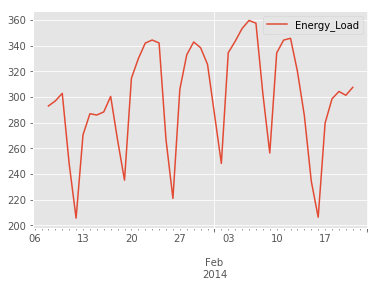

In [7]:
df.loc['2014-02-01','Energy_Load'] = (325.547854 + 248.323577)/2.
df.loc['2014-01-08':'2014-02-21'].plot()

In [8]:
df1 = df.resample('1M').sum()[['Energy_Load']]
df1['date'] = df1.index
df1['year'] = df1.date.dt.year
df1['month'] = df1.date.dt.month
df1.shape

(197, 4)

In [9]:
df1.iloc[np.r_[0:3, -3:0]]

,Energy_Load,date,year,month
2005-01-31,5812.802010,2005-01-31,2005,1
2005-02-28,5400.981390,2005-02-28,2005,2
2005-03-31,6082.353690,2005-03-31,2005,3
2021-03-31,9614.946489,2021-03-31,2021,3
2021-04-30,8606.498493,2021-04-30,2021,4
2021-05-31,8463.734421,2021-05-31,2021,5


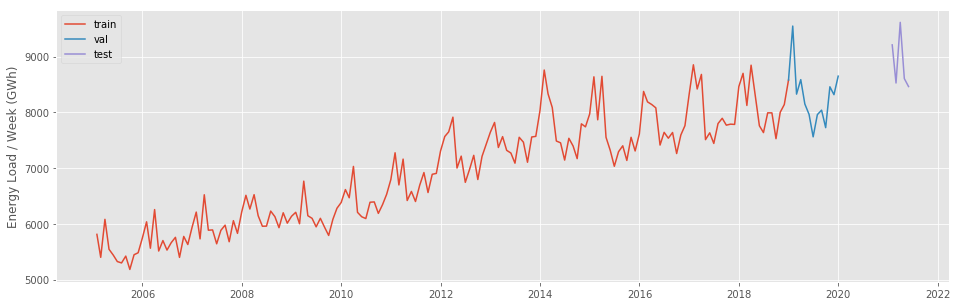

In [10]:
plt.figure(figsize=[16,5])
plt.plot(df1.loc['2005-01-01':'2018-12-31','Energy_Load'], label="train")
plt.plot(df1.loc['2018-12-31':'2019-12-31','Energy_Load'], label="val")
plt.plot(df1.loc['2021-01-01':'2021-05-31','Energy_Load'], label="test")
plt.legend()
plt.ylabel('Energy Load / Week (GWh)')
plt.show()

### Train-test split

In [11]:
windows = 3

In [12]:
train = df1.loc['2005-01-01':'2018-12-31']
print(train.shape)
train.iloc[np.r_[0:2, -2:0]]

(168, 4)


,Energy_Load,date,year,month
2005-01-31,5812.802010,2005-01-31,2005,1
2005-02-28,5400.981390,2005-02-28,2005,2
2018-11-30,8140.952037,2018-11-30,2018,11
2018-12-31,8580.341897,2018-12-31,2018,12


In [13]:
val = pd.concat([train.iloc[-12:], df1.loc['2019-01-01':'2019-12-31'] ], axis=0)
print(val.shape)
val.iloc[np.r_[0:6, -2:0]]

(24, 4)


,Energy_Load,date,year,month
2018-01-31,8700.763152,2018-01-31,2018,1
2018-02-28,8124.509895,2018-02-28,2018,2
2018-03-31,8847.021982,2018-03-31,2018,3
2018-04-30,8311.572371,2018-04-30,2018,4
2018-05-31,7760.197577,2018-05-31,2018,5
2018-06-30,7637.973069,2018-06-30,2018,6
2019-11-30,8317.804701,2019-11-30,2019,11
2019-12-31,8650.069685,2019-12-31,2019,12


In [14]:
year2020 = df1[df1.year==2020]
year2019 = df1[df1.year==2019]
# test = pd.concat([year2020.iloc[-windows:], df1.loc['2021-01-01':'2021-05-31'] ], axis=0)
test = pd.concat([year2019, df1.loc['2021-01-01':'2021-05-31'] ], axis=0)
print(test.shape)
test.iloc[np.r_[0:3, -2:0]]

(17, 4)


,Energy_Load,date,year,month
2019-01-31,9548.465809,2019-01-31,2019,1
2019-02-28,8327.847226,2019-02-28,2019,2
2019-03-31,8587.788770,2019-03-31,2019,3
2021-04-30,8606.498493,2021-04-30,2021,4
2021-05-31,8463.734421,2021-05-31,2021,5


## Data Pre-Processing

**Inputs:**
- windows values
- month -> one-hot (11)  //  binary (4)
- x (t-12)

In [15]:
max_ = 8854.093328099998 # np.max(X.iloc[:,4:].values)
min_ = 5183.659522000001 #np.min(X.iloc[:,4:].values)
lt_w = ['x[t-{}]'.format(str(i)) for i in reversed(range(1, windows+1))]
cols = ['m[0]', 'm[1]', 'm[2]', 'm[3]', 'x[t-12]'] + lt_w + ['x[t]']

def preprocess(df_, t=12):
    '''
    t: datos del mes T-t
    '''
    
    _xt = []
    for i in range(12, len(df_)):
        _y = df_.iloc[i]
        _m = _y.month
        _m = [float(i) for i in np.binary_repr(_m, width=4)]
        _xt_w = list(df_.iloc[i-windows:i].Energy_Load.values)
        _xt_12 = df_.iloc[i-12].Energy_Load

        _x = _m + [_xt_12] + _xt_w + [_y.Energy_Load]
        _xt.append(_x)
        
    _X = pd.DataFrame(_xt, columns=cols)
    _X.iloc[:,4:] = (_X.iloc[:,4:] - min_)/(max_ - min_)
    
    return _X

In [16]:
X = preprocess(train)
X.head()

,m[0],m[1],m[2],m[3],x[t-12],x[t-3],x[t-2],x[t-1],x[t]
0,0.0,0.0,0.0,1.0,0.171408,0.071880,0.081544,0.153548,0.232735
1,0.0,0.0,1.0,0.0,0.059209,0.081544,0.153548,0.232735,0.103735
2,0.0,0.0,1.0,1.0,0.244847,0.153548,0.232735,0.103735,0.292497
3,0.0,1.0,0.0,0.0,0.098563,0.232735,0.103735,0.292497,0.090061
4,0.0,1.0,0.0,1.0,0.070275,0.103735,0.292497,0.090061,0.141132


In [17]:
Xval = preprocess(val)
Xval.head()

,m[0],m[1],m[2],m[3],x[t-12],x[t-3],x[t-2],x[t-1],x[t]
0,0.0,0.0,0.0,1.0,0.958226,0.767954,0.805707,0.925417,1.189180
1,0.0,0.0,1.0,0.0,0.801227,0.805707,0.925417,1.189180,0.856626
2,0.0,0.0,1.0,1.0,0.998073,0.925417,1.189180,0.856626,0.927446
3,0.0,1.0,0.0,0.0,0.852192,1.189180,0.856626,0.927446,0.808223
4,0.0,1.0,0.0,1.0,0.701971,0.856626,0.927446,0.808223,0.757663


In [18]:
Xtest = preprocess(test)
Xtest.head()

,m[0],m[1],m[2],m[3],x[t-12],x[t-3],x[t-2],x[t-1],x[t]
0,0.0,0.0,0.0,1.0,1.189180,0.892445,0.853890,0.944414,1.097332
1,0.0,0.0,1.0,0.0,0.856626,0.853890,0.944414,1.097332,0.910962
2,0.0,0.0,1.0,1.0,0.927446,0.944414,1.097332,0.910962,1.207292
3,0.0,1.0,0.0,0.0,0.808223,1.097332,0.910962,1.207292,0.932543
4,0.0,1.0,0.0,1.0,0.757663,0.910962,1.207292,0.932543,0.893648


In [19]:
x_train = X.values[:,:-1]
y_train = X.values[:,-1]

x_val = Xval.values[:,:-1]
y_val = Xval.values[:,-1] # y[t+1]

x_test = Xtest.values[:,:-1]
y_test = Xtest.values[:,-1] # y[t+1]

# Model

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [21]:
def create_model(hidden_neurons=[4], lr=0.05, n_input=1):
    tf.set_random_seed(42)
    model = Sequential()
    model.add(Dense(hidden_neurons[0], input_dim=n_input, activation='relu'))
    for i in range(1,len(hidden_neurons)):
        model.add(Dense(hidden_neurons[i], input_dim=hidden_neurons[i-1], activation='relu'))
    model.add(Dense(1))
    opt = Adam(learning_rate=lr)
    model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_squared_error'])
    return model

In [22]:
def calculate_metrics(y_true, y_predict, rescaling=True):
    
    if rescaling:
        y_true = y_true*(max_- min_) + min_
        y_predict = y_predict*(max_ - min_) + min_

    mae_error = mean_absolute_error(y_true, y_predict)
    mse_error = mean_squared_error(y_true, y_predict)
    rmse_error = np.sqrt(mse_error)
    mape = np.mean(np.abs((y_true.ravel() - y_predict.ravel()) / y_true.ravel())) * 100


    print(f'Erro MAE = {round(mae_error,3)}\nErro RMSE = {round(rmse_error,3)}')
    print("MAPE: ", np.round(mape,3), "%")

In [23]:
def multistep(x_, y_, model_, mode="binary"):

    yp = []
    
    if mode=="binary":
        L=4
    elif mode=="Nof1":
        L=12

    input_ = np.copy(x_)
    input_ = np.expand_dims(input_[0], axis=0)

    for i in range(len(x_)):
        yt_ = model_.predict(input_)[0][0]
        yp.append(yt_)
        
        if i < len(x_)-1:
            # update input
            input_[0,:L] = x_[i+1,:L] # copy binary part
            input_[0,L:-1] = input_[0,(L+1):]
            input_[0,-1] = yt_

    return np.array(yp)

In [24]:
hn = 10
ep = 40

model1 = create_model(hidden_neurons = [hn], n_input = x_train.shape[1], lr = 0.001)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [93]:
hs1 = model1.fit(x=x_train, y=y_train, epochs=ep,
                 validation_data=(x_val, y_val))

Train on 156 samples, validate on 12 samples
Epoch 1/40
156/156 [==============================] - 0s 1ms/sample - loss: 0.4227 - mean_squared_error: 0.2479 - val_loss: 0.5304 - val_mean_squared_error: 0.3857
Epoch 2/40
156/156 [==============================] - 0s 90us/sample - loss: 0.3898 - mean_squared_error: 0.2124 - val_loss: 0.4860 - val_mean_squared_error: 0.3243
Epoch 3/40
156/156 [==============================] - 0s 83us/sample - loss: 0.3599 - mean_squared_error: 0.1853 - val_loss: 0.4408 - val_mean_squared_error: 0.2702
Epoch 4/40
156/156 [==============================] - 0s 90us/sample - loss: 0.3317 - mean_squared_error: 0.1587 - val_loss: 0.3976 - val_mean_squared_error: 0.2250
Epoch 5/40
156/156 [==============================] - 0s 96us/sample - loss: 0.3093 - mean_squared_error: 0.1393 - val_loss: 0.3596 - val_mean_squared_error: 0.1892
Epoch 6/40
156/156 [==============================] - 0s 106us/sample - loss: 0.2934 - mean_squared_error: 0.1246 - val_loss: 0.332

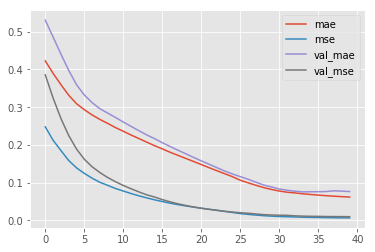

In [94]:
plt.plot(hs1.history['loss'], label="mae")
plt.plot(hs1.history['mean_squared_error'], label="mse")
plt.plot(hs1.history['val_loss'], label="val_mae")
plt.plot(hs1.history['val_mean_squared_error'], label="val_mse")
plt.legend()
plt.show()

In [25]:
file_sav = 'res/bs_hn{}_ep{}.h5'.format(hn, ep)
model1.load_weights(file_sav)

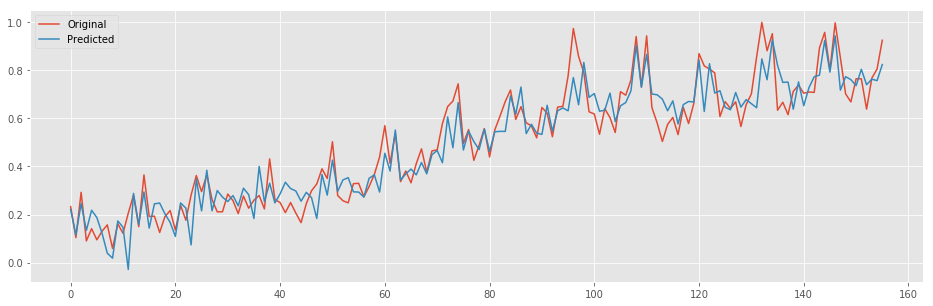

In [26]:
y_train_hat = model1.predict(x_train)

plt.figure(figsize=[16,5])
plt.plot(y_train)
plt.plot(y_train_hat)
plt.legend(['Original','Predicted'])

In [27]:
y_val_ms = multistep(x_val, y_val, model1)

In [28]:
calculate_metrics(y_val, y_val_ms)

Erro MAE = 385.754
Erro RMSE = 476.488
MAPE:  4.703 %


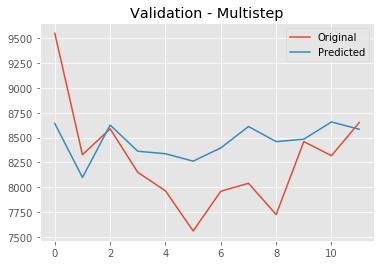

In [29]:
plt.plot(y_val*(max_- min_) + min_)
plt.plot(y_val_ms*(max_- min_) + min_)
plt.legend(['Original','Predicted'])
plt.title('Validation - Multistep')
plt.show()

# Testing

In [30]:
y_test_hat = model1.predict(x_test)
y_test_ms = multistep(x_test, y_test, model1)

In [33]:
calculate_metrics(y_test, y_test_ms)

Erro MAE = 251.419
Erro RMSE = 380.941
MAPE:  2.733 %


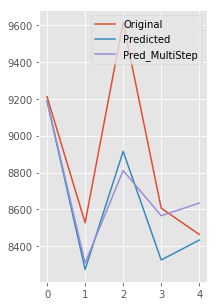

In [34]:
plt.figure(figsize=[3,5])
plt.plot(y_test*(max_- min_) + min_)
plt.plot(y_test_hat.ravel()*(max_- min_) + min_)
plt.plot(y_test_ms*(max_- min_) + min_)
plt.legend(['Original','Predicted', 'Pred_MultiStep'])
plt.show()

In [110]:
# file_sav = 'res/bs_hn{}_ep{}.h5'.format(hn, ep)
# model1.save_weights(file_sav)